Since a few years ago, electricity smart meetings are implemented in many countries. Those readers are able to read data regarding active electricity (several times per hour),
maximum values (contrated power), reactive power, etc. Even more, we are also able to connect to our home readers (from the distributor web portal) and check, even in real time, this information.

In the case of Spain (and several other countries too) due to fluctuations of pricing, we have a system where there is a electricity auction everyday 24 hours a day with different pricings for each hour. Thefore, yearly there are 7.860 different electricy prices.

Also, due to different tariffs, we can select 1 or 2 periods tariff (there are more options). 
During 1 period tariff, althogh prices are different for each hour, they do not vary more than 10 - 15%. But with 2 periods tariff, the difference from the peak to valley period differ more than 60%.

During this article, we will review how data is exported from systems how to review data, check concumptions, patterns and some ideas about how to reduce your electricity bill.

We will be using Watson Studio, Python and pandas library.
***


In [47]:
import csv
import pandas as pd
import numpy as np
import datetime
import re
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

#@hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_41fec274390c40e882bc41e47a9b7b7c = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='JlQNbht0wvyi3wpvE65SRHAy9z05jpt_IYtR0RwSFOLQ',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_41fec274390c40e882bc41e47a9b7b7c.get_object(Bucket='test42-donotdelete-pr-5iqv8c0qc3mskm',Key='house2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

electricity_df = pd.read_csv(body,";", names = ['CUPS', 'Date', 'Hour', 'Consumption','Method'])

#--------------------------First file loaded

body = client_41fec274390c40e882bc41e47a9b7b7c.get_object(Bucket='test42-donotdelete-pr-5iqv8c0qc3mskm',Key='PVPC2.0DHA2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

pricing_2Per_df = pd.read_csv(body,";")

#-------------------------- Second file loaded

body = client_41fec274390c40e882bc41e47a9b7b7c.get_object(Bucket='test42-donotdelete-pr-5iqv8c0qc3mskm',Key='PVPC2.0A2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

pricing_1Per_df = pd.read_csv(body,";")

#-------------------------- Third file loaded

electricity_df.head()


,CUPS,Date,Hour,Consumption,Method
0,ES002200000000CA,01/01/2018,1,0.088,Real
1,ES002200000000CA,01/01/2018,2,0.095,Real
2,ES002200000000CA,01/01/2018,3,0.099,Real
3,ES002200000000CA,01/01/2018,4,0.092,Real
4,ES002200000000CA,01/01/2018,5,0.088,Real


In [48]:
#include day of the week for each read.
weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")

electricity_df['Date']=pd.to_datetime(electricity_df['Date'],format='%d/%m/%Y') #Convert string into datetime format
DaysOfWeek = [weekDays[electricity_df['Date'][i].weekday()] for i in range (len(electricity_df))]
#DaysOfWeek = [weekDays[datetime.datetime.strptime (electricity_df["Date"][i],'%d/%m/%Y').weekday()] for i in range(len(electricity_df))]
electricity_df.insert(4,"DayOfWeek", DaysOfWeek)
electricity_df.head()

,CUPS,Date,Hour,Consumption,DayOfWeek,Method
0,ES002200000000CA,2018-01-01,1,0.088,Monday,Real
1,ES002200000000CA,2018-01-01,2,0.095,Monday,Real
2,ES002200000000CA,2018-01-01,3,0.099,Monday,Real
3,ES002200000000CA,2018-01-01,4,0.092,Monday,Real
4,ES002200000000CA,2018-01-01,5,0.088,Monday,Real


In [49]:
#Sanity checks & cleaning....
electricity_df.head()
if (len(pricing_2Per_df) == len(electricity_df) == len(pricing_1Per_df)):
    print ("File size are the same in three files (ok): {0} records: {1} days".format(len(pricing_1Per_df), len(pricing_1Per_df)/24))
electricity_df=electricity_df.drop("CUPS", axis=1) #we do not need CUPS id column
electricity_df['Date']=pd.to_datetime(electricity_df['Date']) #Convert string into datetime format
pricing_1Per_df['Date']=pd.to_datetime(pricing_1Per_df['Date']) #Convert string into datetime format
pricing_2Per_df['Date']=pd.to_datetime(pricing_2Per_df['Date']) #Convert string into datetime format


File size are the same in three files (ok): 8760 records: 365.0 days


In [69]:
#Lets calculate the cost for 2.0DHA and 2.0A Tarif.
electricity_df ["PriceA"] = pricing_1Per_df["Price"]
electricity_df ["PriceDHA"] = pricing_2Per_df["Price"]
electricity_df ["CostA"] = electricity_df["Consumption"]*electricity_df["PriceA"]
electricity_df ["CostDHA"] = electricity_df["Consumption"]*electricity_df["PriceDHA"]

electricity_df.head()

,Date,Hour,Consumption,DayOfWeek,Method,PriceA,PriceDHA,CostA,CostDHA
0,2018-01-01,1,0.088,Monday,Real,0.07613,0.02796,0.006699,0.002460
1,2018-01-01,2,0.095,Monday,Real,0.07424,0.02616,0.007053,0.002485
2,2018-01-01,3,0.099,Monday,Real,0.07305,0.02504,0.007232,0.002479
3,2018-01-01,4,0.092,Monday,Real,0.06948,0.02164,0.006392,0.001991
4,2018-01-01,5,0.088,Monday,Real,0.07024,0.02237,0.006181,0.001969


In [51]:
savings=electricity_df.sum()['CostA']-electricity_df.sum()['CostDHA']
costAnnually20A = electricity_df.sum()["CostA"]
print("Cost with a 2.0A tariff (annually) is %5.2f€" % costAnnually20A)

print("A hour discrimination tariff can save you% 5.2f€" % savings,\
      "anually + 27%% taxes (aprox %5.2f€)" % (savings*1.27),"Monthly: (%4.2f€)" % (savings*1.27/12))
print("which is %5.2f%% of savings of using 2.0DHA vs 2.0A"% (savings/costAnnually20A*100))

Cost with a 2.0A tariff (annually) is 350.65€
A hour discrimination tariff can save you 44.51€ anually + 27% taxes (aprox 56.52€) Monthly: (4.71€)
which is 12.69% of savings of using 2.0DHA vs 2.0A


In [52]:

TempValues=pd.DataFrame(electricity_df.groupby(['DayOfWeek']).sum()/365*7)
TempValues.sort_values(by=['Consumption'], inplace=True, ascending=False)
TempValues['Difference']=TempValues['CostA']-TempValues['CostDHA']
TempValues[["Consumption","CostA", "CostDHA", "Difference"]]

,Consumption,CostA,CostDHA,Difference
DayOfWeek,,,,
Monday,8.631115,1.082245,0.961929,0.120316
Tuesday,8.412312,1.062126,0.957511,0.104615
Thursday,7.905858,0.993724,0.859083,0.134641
Wednesday,7.706041,0.967665,0.865164,0.102500
Sunday,7.462537,0.909097,0.777919,0.131178
Friday,7.284545,0.913229,0.779319,0.133910
Saturday,6.456704,0.796649,0.670263,0.126386


<h3>Which days do I consume more? Is it cheaper 2.0A or 2.0DHA all the days?</h3>

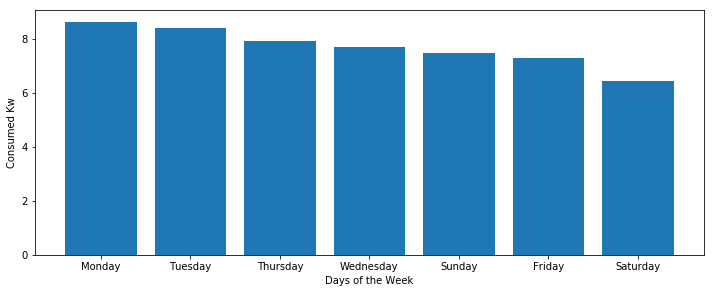

In [53]:
#Show me my consumption in a graph.

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4.5))
plt.ylabel('Consumed Kw')
plt.xlabel('Days of the Week')
plt.bar(TempValues.index,list(TempValues['Consumption']))
plt.show()



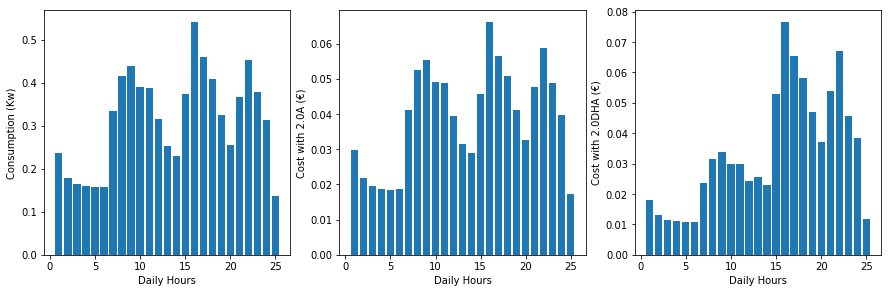

In [54]:
#Let's see what is my hourly consumption and costs using 2.0A & 2.0DHA
TempValues=pd.DataFrame(electricity_df.groupby(['Hour']).mean())
TempValues.sort_values(by=['Consumption'], inplace=True, ascending=False)
TempValues['Difference']=TempValues['CostA']-TempValues['CostDHA']
TempValues[['Consumption','Difference']].head(10)

plt.figure(figsize=(15, 4.5))
plt.subplot(131)
plt.ylabel('Consumption (Kw)')
plt.xlabel('Daily Hours')
plt.bar(TempValues.index,list(TempValues['Consumption']))
plt.subplot(132)
plt.ylabel('Cost with 2.0A (€)')
plt.xlabel('Daily Hours')
plt.bar(TempValues.index,list(TempValues['CostA']))
plt.subplot(133)
plt.ylabel('Cost with 2.0DHA (€)')
plt.xlabel('Daily Hours')
plt.bar(TempValues.index,list(TempValues['CostDHA']))
plt.suptitle("")
plt.show()

<h3>Which hours do I consume more at? Is it cheaper 2.0A or 2.0DHA all the hours?</h2>
As we consume more at peak hours, it is not clear if 2.0DHA is more expensive.
Do you know why?

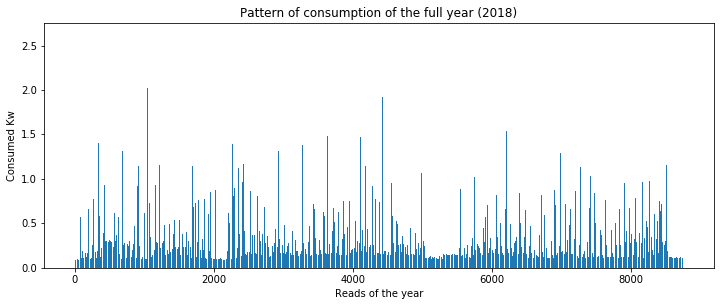

In [55]:
#Show me the dayly consumption in a graph.
plt.figure(figsize=(12, 4.5))
plt.ylabel('Consumed Kw')
plt.xlabel('Reads of the year')
plt.title("Pattern of consumption of the full year (2018)")
plt.bar(electricity_df.index,list(electricity_df['Consumption']))
plt.show()

### Guess where August is?

In [56]:
#Some interesing data about my consumption.
print ("The highest consumption in a specific hour is: %4.2f Kw" % electricity_df['Consumption'].max())
print ("The average consumption during the year is: %5.3f Kw per hour" % (electricity_df.sum()["Consumption"]/365/24))
print ("The average consumption during the year is: %5.3f Kw per day" % (electricity_df.sum()["Consumption"]/365))
print ("I consume daily (as average) %5.3f Kw" % (electricity_df.sum()["Consumption"]/365))

The highest consumption in a specific hour is: 2.62 Kw
The average consumption during the year is: 0.321 Kw per hour
The average consumption during the year is: 7.694 Kw per day
I consume daily (as average) 7.694 Kw


In [57]:
#When hours change (March and October), DHA tariff change as well. Peak interval (during summer time) is from 13:00h upto 23:00h (10 hours). 
#In winter time, from 12:00 upto 22:00 (10 hours also). Please note that "valley" interval in both cases are 14 hours.

#This calculation is based on the way electric companies store information about changing time. Not GMT time!!!
start_date = [electricity_df["Date"][i] for i in range(len(electricity_df)-1) if (electricity_df["Hour"][i] == 23) & (electricity_df["Hour"][i+1] == 1)]
end_date = [electricity_df["Date"][i] for i in range(len(electricity_df)-1) if electricity_df["Hour"][i] == 25]
print("First ({0}) and Last ({1}) day calculated for knowing when the hour changes in March and October".format(start_date[0].date(), end_date[0].date()))


First (2018-03-25) and Last (2018-10-28) day calculated for knowing when the hour changes in March and October


In [58]:
mask = (electricity_df['Date'] >= start_date[0]) & (electricity_df['Date'] < end_date[0])
electricity_df_Summer = electricity_df.loc[mask]

mask = (electricity_df['Date'] < start_date[0]) | (electricity_df['Date'] >= end_date[0])
electricity_df_Winter = electricity_df.loc[mask]

if (len(electricity_df_Summer) + len(electricity_df_Winter) != len(electricity_df)):
    print("División incorrecta de los periodos")
print ("Total Size: {0} hours: Days: {1}. \nSummer: {2} hours {3} Days\nWinter {4} hours. {5} Days.".\
       format(len(electricity_df), (len(electricity_df))/24, len(electricity_df_Summer)+1, \
              (len(electricity_df_Summer)+1)/24, len(electricity_df_Winter)-1,(len(electricity_df_Winter)-1)/24))

Total Size: 8760 hours: Days: 365.0. 
Summer: 5208 hours 217.0 Days
Winter 3552 hours. 148.0 Days.


##### Summer interval is much bigger than winter.

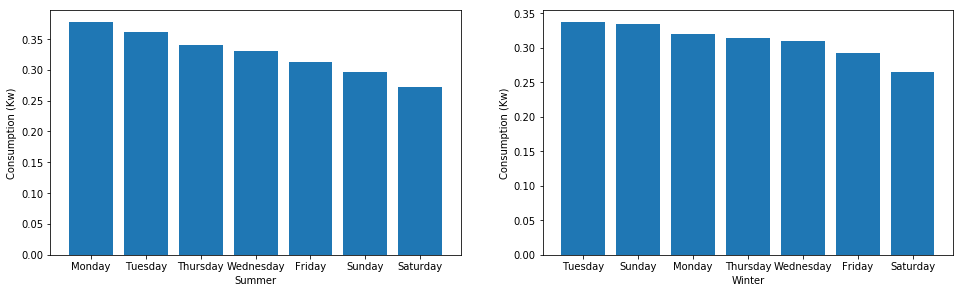

In [59]:
#Show me the consumption in summer and winter.

summer = pd.DataFrame(electricity_df_Summer.groupby(['DayOfWeek']).mean())   
summer.sort_values(by=['Consumption'], inplace=True, ascending=False)

winter = pd.DataFrame(electricity_df_Winter.groupby(['DayOfWeek']).mean())
winter.sort_values(by=['Consumption'], inplace=True, ascending=False)

plt.figure(figsize=(25, 4.5))
plt.subplot(131)
plt.ylabel('Consumption (Kw)')
plt.xlabel('Summer')
plt.bar(summer.index,list(summer['Consumption']))
plt.subplot(132)
plt.ylabel('Consumption (Kw)')
plt.xlabel('Winter')
plt.bar(winter.index,list(winter['Consumption']))
plt.show()

In [60]:
#Looking at data I found something interesting ...

electricity_df.groupby(["Method"]).count()[['Hour']]

,Hour
Method,
Estimada,720
Real,8040


In [61]:
#when does this occur?

FirstDay,LastDay,Estimated="","",""

NumberOfDays=0
print("Date where I have estimated reads:") 
for i in (range(len(electricity_df))):
    if(electricity_df["Method"][i] == "Estimada" and Estimated != electricity_df["Date"][i]):
       Estimated = electricity_df["Date"][i]
       NumberOfDays+=1
       if NumberOfDays == 1: FirstDay = electricity_df["Date"][i]
       LastDay=electricity_df["Date"][i]
       print (Estimated)
print("Number of Estimated days: {0}".format(NumberOfDays))
print ("First day: {0}. Last day: {1}".format(FirstDay.date(), LastDay.date()))

Date where I have estimated reads:
2018-01-17 00:00:00
2018-01-18 00:00:00
2018-01-19 00:00:00
2018-01-20 00:00:00
2018-01-21 00:00:00
2018-01-22 00:00:00
2018-01-23 00:00:00
2018-01-24 00:00:00
2018-01-25 00:00:00
2018-01-26 00:00:00
2018-02-19 00:00:00
2018-02-20 00:00:00
2018-02-21 00:00:00
2018-02-22 00:00:00
2018-02-23 00:00:00
2018-02-24 00:00:00
2018-02-25 00:00:00
2018-02-26 00:00:00
2018-02-27 00:00:00
2018-02-28 00:00:00
2018-03-01 00:00:00
2018-03-02 00:00:00
2018-03-03 00:00:00
2018-03-04 00:00:00
2018-03-05 00:00:00
2018-03-07 00:00:00
2018-03-08 00:00:00
2018-03-09 00:00:00
2018-03-10 00:00:00
2018-03-11 00:00:00
Number of Estimated days: 30
First day: 2018-01-17. Last day: 2018-03-11


In [62]:
if (electricity_df_Summer[electricity_df_Summer.Method == "Estimada"].count().Method == 0):
    print("There are no Estimated reads in Summer")
else:
    print("There are Estimated reads in Summer: {0} hours".format(electricity_df_Summer[electricity_df_Summer.Method == "Estimada"].count().Method))

if (electricity_df_Winter[electricity_df_Winter.Method == "Estimada"].count().Method == 0):
    print("There are no Estimated reads in Winter")
else:
    print("There are Estimated reads in Winter: {0} hours".format(electricity_df_Winter[electricity_df_Winter.Method == "Estimada"].count().Method))
    
    
Temp = pd.DataFrame(electricity_df_Summer.groupby('Method').mean()["Consumption"])
#print("Summer:\n {0}".format(Temp))    
    
Temp = pd.DataFrame(electricity_df_Winter.groupby('Method').mean()["Consumption"])
#print("\nWinter:\n {0}".format(Temp))   

There are no Estimated reads in Summer
There are Estimated reads in Winter: 720 hours


In [63]:
# by hour (Estimated vs Real)
#Temp2 = pd.DataFrame(electricity_df.groupby(['Hour', 'Method']).mean()["Consumption"])
#print(Temp2)

Temp2 = pd.DataFrame(electricity_df_Winter.groupby(['Hour', 'Method']).mean()["Consumption"])

#listofcases= list(Temp2.index.levels[0])
#listofcases.remove(25)
EstimatedValues = [Temp2['Consumption'][i+1][0] for i in range(24)]
RealValues = [Temp2['Consumption'][i+1][1] for i in range(24)]

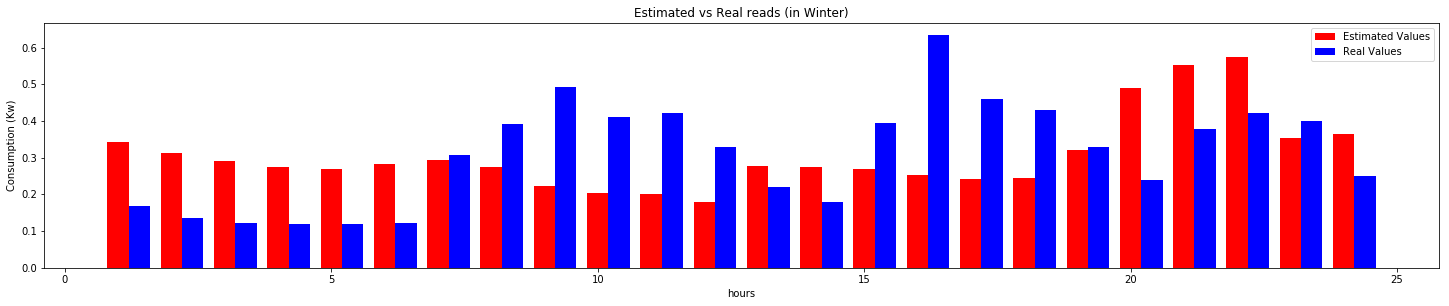

In [64]:
plt.figure(figsize=(25, 4.5))
ax = plt.subplot(111)
plt.ylabel('Consumption (Kw)')
plt.xlabel('hours')

X = np.arange(1,25)
ax.bar(X,EstimatedValues, width=0.4, color='r', align='center', label='Estimated Values')
ax.bar(X+0.4,RealValues, width=0.4, color='b', align='center' ,label='Real Values')
ax.set_title('Estimated vs Real reads (in Winter)')
ax.legend()
plt.show()

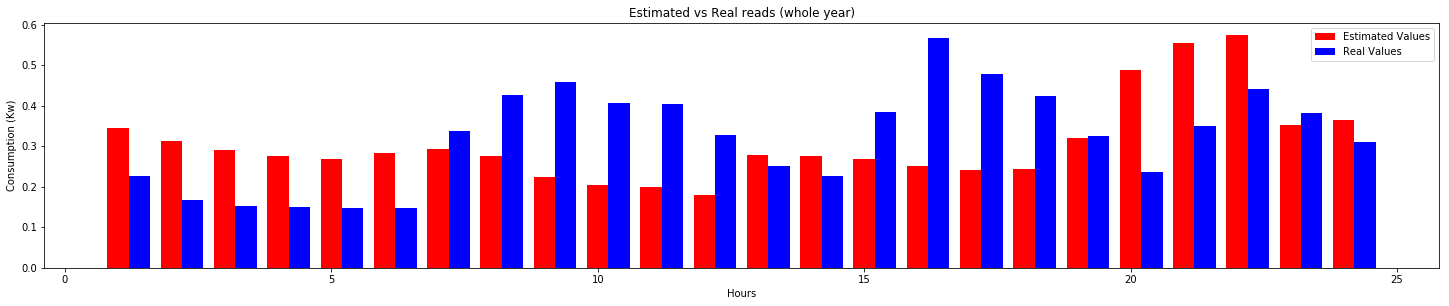

In [65]:
Temp2 = pd.DataFrame(electricity_df.groupby(['Hour', 'Method']).mean()["Consumption"])

listofcases= list(Temp2.index.levels[0])
listofcases.remove(25)
EstimatedValues = [Temp2['Consumption'][i+1][0] for i in range(24)]
RealValues = [Temp2['Consumption'][i+1][1] for i in range(24)]
plt.figure(figsize=(25, 4.5))
ax = plt.subplot(111)
plt.ylabel('Consumption (Kw)')
plt.xlabel('Hours')
ax.set_title('Estimated vs Real reads (whole year)')
X = np.arange(1,25)

ax.bar(X,EstimatedValues, width=0.4, color='r', align='center', label="Estimated Values")
ax.bar(X+0.4,RealValues, width=0.4, color='b', align='center' ,label="Real Values")
ax.legend()
plt.show()

### <center>What do you think? is it more expensive with estimated values or with real values?</center>

In [66]:
#lets see if Cost makes any difference compared with all the year.
mask = (electricity_df['Method'] == "Estimada")
antimask =(electricity_df['Method'] == "Real")
electricity_df_estimated = pd.DataFrame(electricity_df.loc[mask])
electricity_df_real = pd.DataFrame(electricity_df.loc[antimask])

print ("Average cost 2.0A for estimated reads per day %s" % (electricity_df_estimated["CostA"].sum()/30))
print ("Average cost 2.0A for real reads per day %s" % (electricity_df_real["CostA"].sum()/(365-30)))
print ("Average cost 2.0DHA for estimated reads per day %s" % (electricity_df_estimated["CostDHA"].sum()/30))
print ("Average cost 2.0DHA for real reads per day %s" % (electricity_df_real["CostDHA"].sum()/(365-30)))

Average cost 2.0A for estimated reads per day 0.8650162920000001
Average cost 2.0A for real reads per day 0.9692429510149254
Average cost 2.0DHA for estimated reads per day 0.7399956293333333
Average cost 2.0DHA for real reads per day 0.8475840825671641


In [67]:
#lets see if Cost makes any difference compared just with winter
mask = (electricity_df_Winter['Method'] == "Estimada")
antimask =(electricity_df_Winter['Method'] == "Real")
electricity_df_estimated = pd.DataFrame(electricity_df_Winter.loc[mask])
electricity_df_real = pd.DataFrame(electricity_df_Winter.loc[antimask])

print ("Average cost 2.0A for estimated reads per day %s" % (electricity_df_estimated["CostA"].sum()/30))
print ("Average cost 2.0A for real reads per day in winter %s" % (electricity_df_real["CostA"].sum()/(148-30)))
print ("Average cost 2.0DHA for estimated reads per day %s" % (electricity_df_estimated["CostDHA"].sum()/30))
print ("Average cost 2.0DHA for real reads per day in winter %s" % (electricity_df_real["CostDHA"].sum()/(148-30)))

Average cost 2.0A for estimated reads per day 0.8650162920000001
Average cost 2.0A for real reads per day in winter 0.9347789049152542
Average cost 2.0DHA for estimated reads per day 0.7399956293333333
Average cost 2.0DHA for real reads per day in winter 0.8168481022033899


In [68]:
#What if ... I use 2.0DHA and I load a batery with electricity which I offload during peak hours?

